# Offshore wind profiles

In [63]:
# Third-party packages
import h5py
import h5pyd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from scipy.interpolate import interp1d


from scipy.spatial import cKDTree
from tqdm.notebook import trange, tqdm

#%load_ext lab_black

## Power curve

In [64]:
fpath = "/Users/nataliagonzalez/Documents/UCSD PhD/2022/Research 2022/Wave Energy/V2 Work/2020ATB_NREL_Reference_15MW_240.csv"
curve = pd.read_csv(fpath, index_col=0)
curve

,Power [kW],Cp [-]
Wind Speed [m/s],,
3,0,0.000000
4,720,0.406008
5,1239,0.357720
6,2271,0.379442
7,3817,0.401615
8,5876,0.414184
9,8450,0.418322
10,11536,0.416329
11,15000,0.406719


In [65]:
rated_power = 15000  # kW
ws, power = curve.index, curve["Power [kW]"] / rated_power

# Create function to interpolate data. A linear interpolation is sufficient for this dataset
cap_factor_func = interp1d(ws, power, fill_value="extrapolate")

In [66]:
# wtk = h5pyd.File("/nrel/wtk-us.h5", "r")
nw = h5py.File("nw_pacific_2006.h5", mode="r")
ca = h5py.File("offshore_ca_2006.h5", mode="r")
meta_nw = pd.DataFrame(nw["meta"][:])
meta_ca = pd.DataFrame(ca["meta"][:])

In [34]:
from collections import OrderedDict
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, ttest_rel
from scipy.spatial import cKDTree
from pyproj import Proj


def get_WTK_data(h5_file, index=None):

    # Get nearest location based on lat and longitude
    if not index:
        raise NotImplementedError("Function not working for wtk data")
        location_idx = nearest_site(tree, lat, lon)
    else:
        location_idx = index

    # Extract time index and meta data
    time_index = pd.to_datetime(h5_file["time_index"][...].astype(str))
    meta_data = pd.DataFrame(h5_file["meta"][:]).iloc[location_idx].to_dict()

    output_df = pd.DataFrame(index=time_index)

    # Extract SAM required columns and apply scale factor
    for column in [
        # "windspeed_80m",
        # "windspeed_100m",
        # "windspeed_120m",
        "windspeed_160m",
    ]:
        scale_factor = h5_file[column].attrs[
            "scale_factor"
        ]  # Required to convert to normal units
        output_df[column] = h5_file[column][:, location_idx] / scale_factor

    # nsrdb_data = output_df.rename(columns=swc_columns)
    output_df["WTK_idx"] = location_idx

    return output_df, meta_data

In [8]:
locations_1 = pd.read_csv("osw_ca_region_intersect_areas_v2.csv")
locations_1["file"] = "ca"
locations_1

,gid,latitude,longitude,timezone,area_id,area(sq.km),file
0,41562,40.670876,-125.632904,-8,53,2138.797,ca
1,41563,40.689392,-125.634610,-8,53,2138.797,ca
2,41984,40.153965,-125.560940,-8,53,2138.797,ca
3,41985,40.172470,-125.562620,-8,53,2138.797,ca
4,41986,40.190975,-125.564300,-8,53,2138.797,ca
...,...,...,...,...,...,...,...
6201,130039,32.541065,-117.304840,-8,99,1419.395,ca
6202,130040,32.559240,-117.304110,-8,99,1419.395,ca
6203,130041,32.577400,-117.303375,-8,99,1419.395,ca
6204,130042,32.595562,-117.302660,-8,99,1419.395,ca


In [9]:
locations_2 = pd.read_csv("osw_nw_region_intersect_areas_v2.csv")
locations_2["file"] = "nw"
locations_2 = locations_2.loc[~locations_2.area_id.isin([68,39,40,41,42,43,44,45])]
locations_2

,gid,latitude,longitude,timezone,area_id,area(sq.km),file
0,69645,47.960560,-125.300890,-8,1,1285.429,nw
1,69646,47.979170,-125.300995,-8,1,1285.429,nw
2,69647,47.997787,-125.301090,-8,1,1285.429,nw
3,69648,48.016403,-125.301210,-8,1,1285.429,nw
4,70060,47.960630,-125.273100,-8,1,1285.429,nw
...,...,...,...,...,...,...,...
3383,86214,45.609740,-123.983340,-8,17,38.060,nw
3384,86215,45.628380,-123.983000,-8,17,38.060,nw
3385,86216,45.647003,-123.982666,-8,17,38.060,nw
3386,86217,45.665634,-123.982315,-8,17,38.060,nw


In [10]:
locations_2 = locations_2.loc[~locations_2.area_id.isin([68,39,40,41,42,43,44,45])]
locations_2

,gid,latitude,longitude,timezone,area_id,area(sq.km),file
0,69645,47.960560,-125.300890,-8,1,1285.429,nw
1,69646,47.979170,-125.300995,-8,1,1285.429,nw
2,69647,47.997787,-125.301090,-8,1,1285.429,nw
3,69648,48.016403,-125.301210,-8,1,1285.429,nw
4,70060,47.960630,-125.273100,-8,1,1285.429,nw
...,...,...,...,...,...,...,...
3383,86214,45.609740,-123.983340,-8,17,38.060,nw
3384,86215,45.628380,-123.983000,-8,17,38.060,nw
3385,86216,45.647003,-123.982666,-8,17,38.060,nw
3386,86217,45.665634,-123.982315,-8,17,38.060,nw


In [11]:
locations_1['area_id'].unique()

array([53, 52, 68, 94, 61, 50, 51, 49, 54, 48, 39, 59, 40, 45, 47, 43, 42,
       41, 55, 46, 44, 62, 66, 57, 60, 58, 63, 64, 65, 67, 71, 73, 75, 69,
       70, 72, 74, 76, 82, 98, 80, 77, 78, 93, 81, 84, 83, 92, 85, 89, 87,
       90, 88, 86, 91, 95, 96, 97, 99])

In [12]:
locations_2['area_id'].unique()

array([ 1, 56, 38,  2, 15,  0,  3, 26, 25, 31,  4, 37, 29, 36,  5,  6,  7,
       35, 34,  8, 30, 23, 27, 22,  9, 33, 32, 12, 10, 16, 24, 28, 11, 21,
       20, 14, 13, 19, 18, 17])

In [13]:
loc_check = pd.concat([locations_1, locations_2], ignore_index=True)
for i in range(100):
    print(i in loc_check['area_id'].unique(), i)

True 0
True 1
True 2
True 3
True 4
True 5
True 6
True 7
True 8
True 9
True 10
True 11
True 12
True 13
True 14
True 15
True 16
True 17
True 18
True 19
True 20
True 21
True 22
True 23
True 24
True 25
True 26
True 27
True 28
True 29
True 30
True 31
True 32
True 33
True 34
True 35
True 36
True 37
True 38
True 39
True 40
True 41
True 42
True 43
True 44
True 45
True 46
True 47
True 48
True 49
True 50
True 51
True 52
True 53
True 54
True 55
True 56
True 57
True 58
True 59
True 60
True 61
True 62
True 63
True 64
True 65
True 66
True 67
True 68
True 69
True 70
True 71
True 72
True 73
True 74
True 75
True 76
True 77
True 78
False 79
True 80
True 81
True 82
True 83
True 84
True 85
True 86
True 87
True 88
True 89
True 90
True 91
True 92
True 93
True 94
True 95
True 96
True 97
True 98
True 99


In [14]:
locations = pd.concat([locations_1, locations_2], ignore_index=True)
locations.loc[:, "done"] = 0

In [15]:
locations

,gid,latitude,longitude,timezone,area_id,area(sq.km),file,done
0,41562,40.670876,-125.632904,-8,53,2138.797,ca,0
1,41563,40.689392,-125.634610,-8,53,2138.797,ca,0
2,41984,40.153965,-125.560940,-8,53,2138.797,ca,0
3,41985,40.172470,-125.562620,-8,53,2138.797,ca,0
4,41986,40.190975,-125.564300,-8,53,2138.797,ca,0
...,...,...,...,...,...,...,...,...
9202,86214,45.609740,-123.983340,-8,17,38.060,nw,0
9203,86215,45.628380,-123.983000,-8,17,38.060,nw,0
9204,86216,45.647003,-123.982666,-8,17,38.060,nw,0
9205,86217,45.665634,-123.982315,-8,17,38.060,nw,0


In [50]:
fpath = "/Users/nataliagonzalez/Documents/UCSD PhD/2022/Research 2022/Wave Energy/V2 Work/diablo_canyon_nrel_osw_intersect.csv"
data_dc = pd.read_csv(fpath)
data_dc

,gid,latitude,longitude,timezone,elevation,offshore,country,state,county,Area_Name,Sq_Miles,Acres,Hectares,Sq_NMI,Shape_Leng,Shape_Area,Sq_Km
0,104039,35.231106,-121.661420,-8,False,True,b'United States',b'None',b'None',Diablo Canyon,556.543,356188.0,144144.0,420.257,175199.9999,1.441440e+09,1441.44
1,104040,35.249440,-121.661896,-8,False,True,b'United States',b'None',b'None',Diablo Canyon,556.543,356188.0,144144.0,420.257,175199.9999,1.441440e+09,1441.44
2,104041,35.267773,-121.662350,-8,False,True,b'United States',b'None',b'None',Diablo Canyon,556.543,356188.0,144144.0,420.257,175199.9999,1.441440e+09,1441.44
3,104266,35.158165,-121.637146,-8,False,True,b'United States',b'None',b'None',Diablo Canyon,556.543,356188.0,144144.0,420.257,175199.9999,1.441440e+09,1441.44
4,104267,35.176490,-121.637600,-8,False,True,b'United States',b'None',b'None',Diablo Canyon,556.543,356188.0,144144.0,420.257,175199.9999,1.441440e+09,1441.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,108740,34.999966,-121.163360,-8,False,True,b'United States',b'None',b'None',Diablo Canyon,556.543,356188.0,144144.0,420.257,175199.9999,1.441440e+09,1441.44
338,108741,35.018284,-121.163680,-8,False,True,b'United States',b'None',b'None',Diablo Canyon,556.543,356188.0,144144.0,420.257,175199.9999,1.441440e+09,1441.44
339,108742,35.036610,-121.164000,-8,False,True,b'United States',b'None',b'None',Diablo Canyon,556.543,356188.0,144144.0,420.257,175199.9999,1.441440e+09,1441.44
340,108743,35.054930,-121.164340,-8,False,True,b'United States',b'None',b'None',Diablo Canyon,556.543,356188.0,144144.0,420.257,175199.9999,1.441440e+09,1441.44


In [51]:
data_dc = data_dc.drop(columns=['elevation','offshore','country','state','county','Area_Name','Sq_Miles','Acres','Hectares','Sq_NMI','Shape_Leng','Shape_Area'])
data_dc

,gid,latitude,longitude,timezone,Sq_Km
0,104039,35.231106,-121.661420,-8,1441.44
1,104040,35.249440,-121.661896,-8,1441.44
2,104041,35.267773,-121.662350,-8,1441.44
3,104266,35.158165,-121.637146,-8,1441.44
4,104267,35.176490,-121.637600,-8,1441.44
...,...,...,...,...,...
337,108740,34.999966,-121.163360,-8,1441.44
338,108741,35.018284,-121.163680,-8,1441.44
339,108742,35.036610,-121.164000,-8,1441.44
340,108743,35.054930,-121.164340,-8,1441.44


In [52]:
data_dc['area_id'] = 100
data_dc['file'] = 'ca'
data_dc['done'] = 0
data_dc.rename(columns={'Sq_Km':'area(sq.km)'},inplace=True)
data_dc = data_dc[['gid', 'latitude', 'longitude', 'timezone', 'area_id', 'area(sq.km)', 'file','done']]
data_dc

,gid,latitude,longitude,timezone,area_id,area(sq.km),file,done
0,104039,35.231106,-121.661420,-8,100,1441.44,ca,0
1,104040,35.249440,-121.661896,-8,100,1441.44,ca,0
2,104041,35.267773,-121.662350,-8,100,1441.44,ca,0
3,104266,35.158165,-121.637146,-8,100,1441.44,ca,0
4,104267,35.176490,-121.637600,-8,100,1441.44,ca,0
...,...,...,...,...,...,...,...,...
337,108740,34.999966,-121.163360,-8,100,1441.44,ca,0
338,108741,35.018284,-121.163680,-8,100,1441.44,ca,0
339,108742,35.036610,-121.164000,-8,100,1441.44,ca,0
340,108743,35.054930,-121.164340,-8,100,1441.44,ca,0


In [53]:
df_list = []
for row in tqdm(data_dc.itertuples(), total=len(data_dc)):
    # if row["field_1"] in data_dc["done"].values:
    #     continue
    index = row[0]
    wtk_index = row[1]
    site_id = row[5]
    lat = row[2]
    lon = row[3]
    column_name = "{wtk_index}_CF_160m"
    if row[7] == "ca":
        wtkd_data, meta_wtk = get_WTK_data(ca, index=wtk_index)
    else:
        wtkd_data, meta_wtk = get_WTK_data(nw, index=wtk_index)
    wtkd_data[column_name] = cap_factor_func(wtkd_data["windspeed_160m"])
    wtkd_data.loc[wtkd_data["windspeed_160m"] < 4, column_name] = 0
    wtkd_data.loc[wtkd_data["windspeed_160m"] > 25, column_name] = 0
    wtkd_data.loc[:, "site_id"] = site_id
    df_list.append(wtkd_data)
    annual_cf = wtkd_data[column_name].mean()
    data_dc.loc[index, "AC_capacity_factor"] = annual_cf
    data_dc.loc[index, "done"] = wtkd_data["WTK_idx"].unique()[0]
    data_dc.loc[index, "WTK_lat"] = meta_wtk.get("latitude")
    data_dc.loc[index, "WTK_lon"] = meta_wtk.get("longitude")

  0%|          | 0/342 [00:00<?, ?it/s]

<ipython-input-53-16565edd9e19>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dc.loc[index, "AC_capacity_factor"] = annual_cf
<ipython-input-53-16565edd9e19>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dc.loc[index, "WTK_lat"] = meta_wtk.get("latitude")
<ipython-input-53-16565edd9e19>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [55]:
data_dc.to_csv('osw_data_dc_final.csv')
data_dc

,gid,latitude,longitude,timezone,area_id,area(sq.km),file,done,AC_capacity_factor,WTK_lat,WTK_lon
0,104039,35.231106,-121.661420,-8,100,1441.44,ca,104039,0.503798,35.231106,-121.661423
1,104040,35.249440,-121.661896,-8,100,1441.44,ca,104040,0.502135,35.249439,-121.661896
2,104041,35.267773,-121.662350,-8,100,1441.44,ca,104041,0.500236,35.267773,-121.662354
3,104266,35.158165,-121.637146,-8,100,1441.44,ca,104266,0.510277,35.158165,-121.637146
4,104267,35.176490,-121.637600,-8,100,1441.44,ca,104267,0.508089,35.176491,-121.637604
...,...,...,...,...,...,...,...,...,...,...,...
337,108740,34.999966,-121.163360,-8,100,1441.44,ca,108740,0.493659,34.999966,-121.163361
338,108741,35.018284,-121.163680,-8,100,1441.44,ca,108741,0.490142,35.018284,-121.163681
339,108742,35.036610,-121.164000,-8,100,1441.44,ca,108742,0.486617,35.036610,-121.164001
340,108743,35.054930,-121.164340,-8,100,1441.44,ca,108743,0.483011,35.054932,-121.164337


In [17]:
locations

,gid,latitude,longitude,timezone,area_id,area(sq.km),file,done,AC_capacity_factor,WTK_lat,WTK_lon
0,41562,40.670876,-125.632904,-8,53,2138.797,ca,41562,0.665081,40.670876,-125.632904
1,41563,40.689392,-125.634610,-8,53,2138.797,ca,41563,0.665306,40.689392,-125.634613
2,41984,40.153965,-125.560940,-8,53,2138.797,ca,41984,0.671961,40.153965,-125.560944
3,41985,40.172470,-125.562620,-8,53,2138.797,ca,41985,0.671688,40.172470,-125.562622
4,41986,40.190975,-125.564300,-8,53,2138.797,ca,41986,0.671192,40.190975,-125.564301
...,...,...,...,...,...,...,...,...,...,...,...
9202,86214,45.609740,-123.983340,-8,17,38.060,nw,86214,0.471754,45.609741,-123.983337
9203,86215,45.628380,-123.983000,-8,17,38.060,nw,86215,0.474352,45.628380,-123.983002
9204,86216,45.647003,-123.982666,-8,17,38.060,nw,86216,0.477602,45.647003,-123.982666
9205,86217,45.665634,-123.982315,-8,17,38.060,nw,86217,0.481466,45.665634,-123.982315


In [18]:
locations.to_csv('osw_locations_final.csv')

In [19]:
wtkd_data

,windspeed_160m,WTK_idx,{wtk_index}_CF_160m,site_id
2006-01-01 00:00:00+00:00,9.19,86218,0.602423,17
2006-01-01 01:00:00+00:00,10.09,86218,0.789851,17
2006-01-01 02:00:00+00:00,12.61,86218,1.000000,17
2006-01-01 03:00:00+00:00,11.99,86218,1.000000,17
2006-01-01 04:00:00+00:00,11.79,86218,1.000000,17
...,...,...,...,...
2006-12-31 19:00:00+00:00,2.15,86218,0.000000,17
2006-12-31 20:00:00+00:00,3.50,86218,0.000000,17
2006-12-31 21:00:00+00:00,3.93,86218,0.000000,17
2006-12-31 22:00:00+00:00,3.35,86218,0.000000,17


In [20]:
wtkd_data.to_csv('osw_wtk_data_final.csv')

In [57]:
test = data_dc.loc[:, ["gid", "area_id"]]
test["names"] = test["gid"].astype(str) + "_" + test["area_id"].astype(str)
test

,gid,area_id,names
0,104039,100,104039_100
1,104040,100,104040_100
2,104041,100,104041_100
3,104266,100,104266_100
4,104267,100,104267_100
...,...,...,...
337,108740,100,108740_100
338,108741,100,108741_100
339,108742,100,108742_100
340,108743,100,108743_100


In [58]:
test.area_id.unique()

array([100])

In [59]:
names = test["names"].values
# names_ = np.append(names, ["z"])

In [60]:
data_merged = pd.concat(df_list, axis=1)
data_merged = data_merged.filter(regex="(\d*)_CF_160m")
data_merged.columns = names
data_merged

,104039_100,104040_100,104041_100,104266_100,104267_100,104268_100,104269_100,104270_100,104271_100,104492_100,...,108546_100,108736_100,108737_100,108738_100,108739_100,108740_100,108741_100,108742_100,108743_100,108744_100
2006-01-01 00:00:00+00:00,0.622996,0.608595,0.618881,0.746436,0.705289,0.664143,0.633283,0.627111,0.641512,0.806016,...,0.808325,0.905317,0.893771,0.877605,0.856821,0.836037,0.819872,0.808325,0.799088,0.799088
2006-01-01 01:00:00+00:00,0.347808,0.339572,0.332709,0.357417,0.361535,0.358789,0.350553,0.339572,0.331336,0.353299,...,0.391733,0.515285,0.515285,0.515285,0.511853,0.504989,0.491261,0.472385,0.446645,0.417473
2006-01-01 02:00:00+00:00,0.179228,0.182320,0.185412,0.176136,0.176136,0.177167,0.178197,0.180259,0.182320,0.184381,...,0.328591,0.328591,0.338199,0.346435,0.353299,0.357417,0.358789,0.357417,0.351926,0.345063
2006-01-01 03:00:00+00:00,0.130072,0.133512,0.137640,0.133512,0.134888,0.136264,0.137640,0.139704,0.141768,0.143144,...,0.200872,0.261330,0.259957,0.258585,0.255839,0.252405,0.248283,0.243129,0.236945,0.229731
2006-01-01 04:00:00+00:00,0.085352,0.083976,0.082254,0.092232,0.092920,0.093608,0.093608,0.092232,0.089480,0.095672,...,0.060110,0.088792,0.083288,0.079832,0.077064,0.074296,0.071528,0.068760,0.066338,0.063570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-31 19:00:00+00:00,0.590079,0.563333,0.565391,0.438065,0.434633,0.463805,0.513569,0.549605,0.558185,0.544457,...,0.390361,0.544457,0.520433,0.506705,0.494693,0.458657,0.424337,0.417473,0.420905,0.410609
2006-12-31 20:00:00+00:00,0.653856,0.606537,0.579792,0.551321,0.585964,0.625053,0.629168,0.604480,0.581849,0.742321,...,0.501557,0.434633,0.390361,0.371143,0.367025,0.372516,0.371143,0.360162,0.362907,0.407177
2006-12-31 21:00:00+00:00,0.817563,0.833728,0.815253,0.752608,0.760837,0.769067,0.778304,0.775995,0.746436,0.732035,...,0.479249,0.408893,0.444929,0.467237,0.470669,0.467237,0.462089,0.456941,0.448361,0.441497
2006-12-31 22:00:00+00:00,0.810635,0.956123,1.000000,0.879915,0.764952,0.752608,0.842965,0.976907,1.000000,1.000000,...,0.721748,0.686773,0.740264,0.746436,0.723805,0.709404,0.721748,0.746436,0.767009,0.771376


In [61]:
ttt_ = data_merged.groupby(
    data_merged.columns.str.extract("\d*_(\d+)", expand=False), axis=1
).mean()
ttt_

,100
2006-01-01 00:00:00+00:00,0.888183
2006-01-01 01:00:00+00:00,0.438436
2006-01-01 02:00:00+00:00,0.242994
2006-01-01 03:00:00+00:00,0.200898
2006-01-01 04:00:00+00:00,0.079028
...,...
2006-12-31 19:00:00+00:00,0.497244
2006-12-31 20:00:00+00:00,0.502999
2006-12-31 21:00:00+00:00,0.585540
2006-12-31 22:00:00+00:00,0.811253


In [62]:
ttt_.to_csv('osw_diablo_canyon_time_series_final.csv')

In [74]:
fpath = "/Users/nataliagonzalez/Documents/UCSD PhD/2022/Research 2022/Wave Energy/V2 Work/finalized files/osw_time_series_final_sorted.csv"
ttt_ = pd.read_csv(fpath, index_col=0, parse_dates=True)
ttt_

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
2006-01-01 00:00:00+00:00,0.792742,0.932387,1.000000,0.667128,0.605730,0.397259,0.587856,0.796382,0.706780,0.956757,...,0.999363,0.935007,0.954117,0.294846,1.000000,0.232831,1.000000,0.650397,0.164203,0.888183
2006-01-01 01:00:00+00:00,0.924306,0.900523,0.716974,0.635388,0.474582,0.440243,0.630089,0.536955,0.708090,0.708574,...,0.958989,0.625390,0.779133,0.136419,1.000000,0.080199,0.999914,0.340779,0.152878,0.438436
2006-01-01 02:00:00+00:00,0.536871,0.706829,0.926573,0.646400,0.514262,0.553866,0.672538,0.784647,0.923468,0.979955,...,0.577362,0.504154,0.537303,0.293075,0.799665,0.044157,0.908316,0.192460,0.110145,0.242994
2006-01-01 03:00:00+00:00,0.648541,0.597908,0.652232,0.694145,0.650288,0.726405,0.886050,0.882777,0.948710,0.948740,...,0.447119,0.343722,0.301425,0.814091,0.512282,0.003702,0.691304,0.118170,0.173269,0.200898
2006-01-01 04:00:00+00:00,0.562322,0.479239,0.763120,0.676508,0.607881,0.668868,0.548477,0.812925,0.964986,0.975016,...,0.253480,0.187403,0.122662,1.000000,0.306628,0.205365,0.335900,0.051696,0.188108,0.079028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-31 19:00:00+00:00,0.190997,0.415541,0.473938,0.539678,0.572565,0.440959,0.288487,0.176046,0.162098,0.169759,...,0.826243,0.695503,0.720601,0.000000,0.838924,0.000000,0.000000,0.461491,0.000000,0.497244
2006-12-31 20:00:00+00:00,0.201576,0.428239,0.526317,0.523293,0.486786,0.305436,0.180112,0.115501,0.110532,0.123754,...,0.761587,0.756343,0.787302,0.000000,0.918019,0.000000,0.020233,0.545700,0.000000,0.502999
2006-12-31 21:00:00+00:00,0.173035,0.411829,0.526431,0.506491,0.401241,0.257950,0.140427,0.090443,0.089267,0.087749,...,0.927614,0.828037,0.890730,0.000000,0.804861,0.000000,0.197782,0.726449,0.000000,0.585540
2006-12-31 22:00:00+00:00,0.193051,0.427911,0.521348,0.405061,0.340103,0.219959,0.143084,0.092075,0.090239,0.083057,...,0.986622,0.912942,0.994097,0.000000,1.000000,0.009905,0.188524,0.894879,0.002781,0.811253


In [92]:
ttttt_ = pd.melt(
    ttt_.reset_index(),
    id_vars="index",
    value_name="gen_max_capacity_factor",
    var_name="site",
)
ttttt_ = ttttt_.set_index("index")
ttttt_.loc[:, "generation_project"] = ttttt_.site.apply(
    lambda x: 1400000101+int(x)
)
ttttt_["site"] = ttttt_["site"].astype(int)
ttttt_.loc[:, "year"] = ttttt_.index.year
ttttt_.loc[:, "month"] = ttttt_.index.month
ttttt_.loc[:, "day"] = ttttt_.index.day
ttttt_.loc[:, "hour"] = ttttt_.index.hour

ttttt_[
    [
        "generation_project",
        "gen_max_capacity_factor",
        "site",
        "year",
        "month",
        "day",
        "hour",
    ]
].sort_values(["site", "year", "month", "day", "hour"]).to_csv(
    "offshore_data.csv", index=False)

In [93]:
ttttt_.sort_values("site")

,site,gen_max_capacity_factor,generation_project,year,month,day,hour
index,,,,,,,
2006-01-01 00:00:00+00:00,0,0.792742,1400000101,2006,1,1,0
2006-09-01 16:00:00+00:00,0,1.000000,1400000101,2006,9,1,16
2006-09-01 15:00:00+00:00,0,1.000000,1400000101,2006,9,1,15
2006-09-01 14:00:00+00:00,0,0.999615,1400000101,2006,9,1,14
2006-09-01 13:00:00+00:00,0,0.952993,1400000101,2006,9,1,13
...,...,...,...,...,...,...,...
2006-05-02 16:00:00+00:00,100,0.527221,1400000201,2006,5,2,16
2006-05-02 17:00:00+00:00,100,0.380996,1400000201,2006,5,2,17
2006-05-02 18:00:00+00:00,100,0.324948,1400000201,2006,5,2,18


In [91]:
365*24*101

884760

In [81]:
ttttt_['site'].unique()

array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 80, 81, 82, 93, 94, 98])

Cleaning the offshore input file

In [3]:
fpath = "/Users/nataliagonzalez/Documents/UCSD PhD/2022/Research 2022/Wave Energy/notebooks/osw_time_series_final.csv"
wind_input_data = pd.read_csv(fpath, index_col=0, parse_dates=True)
wind_input_data

,0,1,10,11,12,13,14,15,16,17,...,91,92,93,94,95,96,97,98,99,79
2006-01-01 00:00:00+00:00,0.792742,0.932387,0.967477,0.828802,0.701083,0.590989,0.239007,0.911613,0.668948,0.848341,...,0.999363,0.935007,0.954117,0.294846,1.000000,0.232831,1.000000,0.650397,0.164203,0.287411
2006-01-01 01:00:00+00:00,0.924306,0.900523,0.951696,0.929895,0.838937,0.582535,0.735604,0.996270,0.767448,0.732428,...,0.958989,0.625390,0.779133,0.136419,1.000000,0.080199,0.999914,0.340779,0.152878,0.414041
2006-01-01 02:00:00+00:00,0.536871,0.706829,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.577362,0.504154,0.537303,0.293075,0.799665,0.044157,0.908316,0.192460,0.110145,0.219424
2006-01-01 03:00:00+00:00,0.648541,0.597908,1.000000,1.000000,1.000000,1.000000,1.000000,0.997449,1.000000,1.000000,...,0.447119,0.343722,0.301425,0.814091,0.512282,0.003702,0.691304,0.118170,0.173269,0.072566
2006-01-01 04:00:00+00:00,0.562322,0.479239,1.000000,1.000000,0.996732,1.000000,1.000000,0.963681,0.994192,1.000000,...,0.253480,0.187403,0.122662,1.000000,0.306628,0.205365,0.335900,0.051696,0.188108,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-31 19:00:00+00:00,0.190997,0.415541,0.113732,0.084200,0.118154,0.000000,0.032477,0.128527,0.080624,0.033102,...,0.826243,0.695503,0.720601,0.000000,0.838924,0.000000,0.000000,0.461491,0.000000,0.350553
2006-12-31 20:00:00+00:00,0.201576,0.428239,0.105820,0.066412,0.130175,0.039497,0.096617,0.140633,0.067894,0.038220,...,0.761587,0.756343,0.787302,0.000000,0.918019,0.000000,0.020233,0.545700,0.000000,0.549605
2006-12-31 21:00:00+00:00,0.173035,0.411829,0.112471,0.044320,0.108049,0.063916,0.080777,0.131442,0.077100,0.027260,...,0.927614,0.828037,0.890730,0.000000,0.804861,0.000000,0.197782,0.726449,0.000000,0.616824
2006-12-31 22:00:00+00:00,0.193051,0.427911,0.099227,0.039927,0.071574,0.000000,0.041882,0.116061,0.065489,0.013972,...,0.986622,0.912942,0.994097,0.000000,1.000000,0.009905,0.188524,0.894879,0.002781,0.849893


In [10]:
wind_input_data.columns = wind_input_data.columns.astype(str).astype(int)

In [12]:
wind_input_data.columns

Int64Index([ 0,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
             4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,
            55, 56, 57, 58, 59,  6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,  7,
            70, 71, 72, 73, 74, 75, 76, 77, 78,  8, 80, 81, 82, 83, 84, 85, 86,
            87, 88, 89,  9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 79],
           dtype='int64')

In [13]:
wind_input_data = wind_input_data.reindex(sorted(wind_input_data.columns), axis=1)
wind_input_data

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2006-01-01 00:00:00+00:00,0.792742,0.932387,1.000000,0.667128,0.605730,0.397259,0.587856,0.796382,0.706780,0.956757,...,1.000000,0.999363,0.935007,0.954117,0.294846,1.000000,0.232831,1.000000,0.650397,0.164203
2006-01-01 01:00:00+00:00,0.924306,0.900523,0.716974,0.635388,0.474582,0.440243,0.630089,0.536955,0.708090,0.708574,...,0.743424,0.958989,0.625390,0.779133,0.136419,1.000000,0.080199,0.999914,0.340779,0.152878
2006-01-01 02:00:00+00:00,0.536871,0.706829,0.926573,0.646400,0.514262,0.553866,0.672538,0.784647,0.923468,0.979955,...,0.509208,0.577362,0.504154,0.537303,0.293075,0.799665,0.044157,0.908316,0.192460,0.110145
2006-01-01 03:00:00+00:00,0.648541,0.597908,0.652232,0.694145,0.650288,0.726405,0.886050,0.882777,0.948710,0.948740,...,0.417960,0.447119,0.343722,0.301425,0.814091,0.512282,0.003702,0.691304,0.118170,0.173269
2006-01-01 04:00:00+00:00,0.562322,0.479239,0.763120,0.676508,0.607881,0.668868,0.548477,0.812925,0.964986,0.975016,...,0.264101,0.253480,0.187403,0.122662,1.000000,0.306628,0.205365,0.335900,0.051696,0.188108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-31 19:00:00+00:00,0.190997,0.415541,0.473938,0.539678,0.572565,0.440959,0.288487,0.176046,0.162098,0.169759,...,0.731164,0.826243,0.695503,0.720601,0.000000,0.838924,0.000000,0.000000,0.461491,0.000000
2006-12-31 20:00:00+00:00,0.201576,0.428239,0.526317,0.523293,0.486786,0.305436,0.180112,0.115501,0.110532,0.123754,...,0.790094,0.761587,0.756343,0.787302,0.000000,0.918019,0.000000,0.020233,0.545700,0.000000
2006-12-31 21:00:00+00:00,0.173035,0.411829,0.526431,0.506491,0.401241,0.257950,0.140427,0.090443,0.089267,0.087749,...,0.825742,0.927614,0.828037,0.890730,0.000000,0.804861,0.000000,0.197782,0.726449,0.000000
2006-12-31 22:00:00+00:00,0.193051,0.427911,0.521348,0.405061,0.340103,0.219959,0.143084,0.092075,0.090239,0.083057,...,0.924754,0.986622,0.912942,0.994097,0.000000,1.000000,0.009905,0.188524,0.894879,0.002781


In [14]:
#wind_input_data.to_csv('osw_time_series_final_sorted.csv',index=True)

In [17]:
wind_input_data_switch_format = pd.melt(
    wind_input_data.reset_index(),
    id_vars="index",
    value_name="gen_max_capacity_factor",
    var_name="site",
)
wind_input_data_switch_format = wind_input_data_switch_format.set_index("index")
wind_input_data_switch_format.loc[:, "generation_project"] = wind_input_data_switch_format.site.apply(
    lambda x: f"13000001{int(x)-1:>02}"
)
wind_input_data_switch_format["site"] = wind_input_data_switch_format["site"].astype(int)
wind_input_data_switch_format.loc[:, "year"] = wind_input_data_switch_format.index.year
wind_input_data_switch_format.loc[:, "month"] = wind_input_data_switch_format.index.month
wind_input_data_switch_format.loc[:, "day"] = wind_input_data_switch_format.index.day
wind_input_data_switch_format.loc[:, "hour"] = wind_input_data_switch_format.index.hour

wind_input_data_switch_format[
    [
        "generation_project",
        "gen_max_capacity_factor",
        "site",
        "year",
        "month",
        "day",
        "hour",
    ]
].sort_values(["site", "year", "month", "day", "hour"]).to_csv(
    "offshore_data.csv", index=False)

wind_input_data_switch_format 

,site,gen_max_capacity_factor,generation_project,year,month,day,hour
index,,,,,,,
2006-01-01 00:00:00+00:00,0,0.792742,13000001-1,2006,1,1,0
2006-01-01 01:00:00+00:00,0,0.924306,13000001-1,2006,1,1,1
2006-01-01 02:00:00+00:00,0,0.536871,13000001-1,2006,1,1,2
2006-01-01 03:00:00+00:00,0,0.648541,13000001-1,2006,1,1,3
2006-01-01 04:00:00+00:00,0,0.562322,13000001-1,2006,1,1,4
...,...,...,...,...,...,...,...
2006-12-31 19:00:00+00:00,99,0.000000,1300000198,2006,12,31,19
2006-12-31 20:00:00+00:00,99,0.000000,1300000198,2006,12,31,20
2006-12-31 21:00:00+00:00,99,0.000000,1300000198,2006,12,31,21


In [22]:
len(wind_input_data_switch_format['site'].unique())

100

Misc

In [158]:
scale_factor = wtk["windspeed_160m"].attrs[
    "scale_factor"
]  # Required to convert to normal units
scale_factor

100.0

In [156]:
wtk["windspeed_160m"][:, 123349] / scale_factor

array([15.65, 15.72, 13.17, ...,  4.06,  6.67,  8.75])

In [162]:
candidate_plant = pd.DataFrame(index=time_index)
candidate_plant

""
2019-01-01 00:00:00+00:00
2019-01-01 01:00:00+00:00
2019-01-01 02:00:00+00:00
2019-01-01 03:00:00+00:00
2019-01-01 04:00:00+00:00
...
2019-12-31 19:00:00+00:00
2019-12-31 20:00:00+00:00
2019-12-31 21:00:00+00:00
2019-12-31 22:00:00+00:00


In [165]:
candidate_plant.loc[:, "windspeed_160m"] = (
    wtk["windspeed_160m"][:, 123349] / scale_factor
)
candidate_plant

,windspeed_160m
2019-01-01 00:00:00+00:00,15.65
2019-01-01 01:00:00+00:00,15.72
2019-01-01 02:00:00+00:00,13.17
2019-01-01 03:00:00+00:00,12.45
2019-01-01 04:00:00+00:00,10.91
...,...
2019-12-31 19:00:00+00:00,1.72
2019-12-31 20:00:00+00:00,1.86
2019-12-31 21:00:00+00:00,4.06
2019-12-31 22:00:00+00:00,6.67


In [167]:
candidate_plant[f"CF_160m"] = cap_factor_func(candidate_plant["windspeed_160m"])
candidate_plant.loc[candidate_plant["windspeed_160m"] < 4, f"CF_160m"] = 0
candidate_plant.loc[candidate_plant["windspeed_160m"] > 25, f"CF_160m"] = 0

In [174]:
candidate_plant.to_csv("offshore_candidate_morro_2019.csv")

In [161]:
locations.loc[
    locations["AC_capacity_factor"] == locations["AC_capacity_factor"].median()
]

,wtk_index,latitude,longitude,timezone,elevation,offshore,country,state,county,done,AC_capacity_factor,WTK_lat,WTK_lon
117,123349,35.48506,-121.82568,-8,0,True,b'United States',b'None',b'None',123349,0.55571,35.485062,-121.825684


In [146]:
wtkd_data, meta_wtk = get_WTK_data(f, index=123349)

In [149]:
time_index = pd.to_datetime(wtk["time_index"][...].astype(str))
time_index

DatetimeIndex(['2019-01-01 00:00:00+00:00', '2019-01-01 01:00:00+00:00',
               '2019-01-01 02:00:00+00:00', '2019-01-01 03:00:00+00:00',
               '2019-01-01 04:00:00+00:00', '2019-01-01 05:00:00+00:00',
               '2019-01-01 06:00:00+00:00', '2019-01-01 07:00:00+00:00',
               '2019-01-01 08:00:00+00:00', '2019-01-01 09:00:00+00:00',
               ...
               '2019-12-31 14:00:00+00:00', '2019-12-31 15:00:00+00:00',
               '2019-12-31 16:00:00+00:00', '2019-12-31 17:00:00+00:00',
               '2019-12-31 18:00:00+00:00', '2019-12-31 19:00:00+00:00',
               '2019-12-31 20:00:00+00:00', '2019-12-31 21:00:00+00:00',
               '2019-12-31 22:00:00+00:00', '2019-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8760, freq=None)

In [150]:
wtkd_data.index

DatetimeIndex(['2000-01-01 00:00:00+00:00', '2000-01-01 01:00:00+00:00',
               '2000-01-01 02:00:00+00:00', '2000-01-01 03:00:00+00:00',
               '2000-01-01 04:00:00+00:00', '2000-01-01 05:00:00+00:00',
               '2000-01-01 06:00:00+00:00', '2000-01-01 07:00:00+00:00',
               '2000-01-01 08:00:00+00:00', '2000-01-01 09:00:00+00:00',
               ...
               '2000-12-31 14:00:00+00:00', '2000-12-31 15:00:00+00:00',
               '2000-12-31 16:00:00+00:00', '2000-12-31 17:00:00+00:00',
               '2000-12-31 18:00:00+00:00', '2000-12-31 19:00:00+00:00',
               '2000-12-31 20:00:00+00:00', '2000-12-31 21:00:00+00:00',
               '2000-12-31 22:00:00+00:00', '2000-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8784, freq=None)

In [123]:
pd.concat(df_list, axis=1)  # .loc[:, "117_CF_160m"]

,165_CF_160m,166_CF_160m,167_CF_160m,168_CF_160m,169_CF_160m,170_CF_160m,171_CF_160m,172_CF_160m,173_CF_160m,174_CF_160m,...,225_CF_160m,226_CF_160m,227_CF_160m,228_CF_160m,229_CF_160m,230_CF_160m,231_CF_160m,232_CF_160m,233_CF_160m,234_CF_160m
2000-01-01 00:00:00+00:00,0.345343,0.402352,0.407501,0.398920,0.212391,0.231982,0.257414,0.283518,0.312370,0.332978,...,0.372821,0.353587,0.319239,0.360456,0.367326,0.363204,0.339848,0.361830,0.368699,0.354961
2000-01-01 01:00:00+00:00,0.319239,0.331604,0.354961,0.392056,0.257414,0.284892,0.315118,0.321987,0.302753,0.273901,...,0.378317,0.387934,0.379691,0.393772,0.390682,0.386560,0.382438,0.341222,0.345343,0.237138
2000-01-01 02:00:00+00:00,0.617198,0.648081,0.656317,0.648081,0.519048,0.553370,0.602786,0.621316,0.613080,0.604844,...,0.525912,0.488158,0.453836,0.594550,0.602786,0.584256,0.541357,0.525912,0.586314,0.441823
2000-01-01 03:00:00+00:00,0.666611,0.699553,0.711907,0.720142,0.787991,0.767497,0.753084,0.746908,0.746908,0.740731,...,0.627492,0.606903,0.596609,0.701612,0.627492,0.567784,0.569843,0.666611,0.617198,0.681023
2000-01-01 04:00:00+00:00,0.515616,0.536209,0.548222,0.541357,0.627492,0.664552,0.639846,0.560234,0.493306,0.479577,...,0.629551,0.573961,0.623374,0.720142,0.670729,0.586314,0.549938,0.701612,0.639846,0.676906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-31 19:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-12-31 20:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-12-31 21:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-12-31 22:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [110]:
locations.to_csv("ca_offshore_annual_cf.csv")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

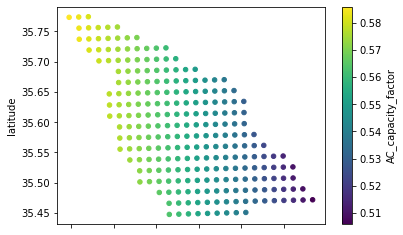

In [108]:
locations.plot.scatter(
    x="longitude", y="latitude", c="AC_capacity_factor", cmap="viridiscmap="viridis"
)

In [69]:
df_list = []
for index, row in tqdm(locations.iterrows(), total=len(locations)):
    wtkd_data, meta_wtk = get_WTK_data(f, lat=row["Latitude"], lon=row["Longitude"])
    wtkd_data[f"{index}_CF_160m"] = cap_factor_func(
        wtkd_data["windspeed_160m"]
    )
    wtkd_data.loc[
        wtkd_data["windspeed_160m"] < 4, f"Site_{int(row['Site']):02}_CF_160m"
    ] = 0
    wtkd_data.loc[
        wtkd_data["windspeed_160m"] > 25, f"Site_{int(row['Site']):02}_CF_160m"
    ] = 0
    df_list.append(wtkd_data[f"Site_{int(row['Site']):02}_CF_160m"])
    annual_cf = wtkd_data[f"Site_{int(row['Site']):02}_CF_160m"].mean()
    locations.loc[index, "AC_capacity_factor"] = annual_cf
    locations.loc[index, "WTK_index"] = wtkd_data["WTK_idx"].unique()[0]
    locations.loc[index, "WTK_lat"] = meta_wtk.get("latitude")
    locations.loc[index, "WTK_lon"] = meta_wtk.get("longitude")

  0%|          | 0/14 [00:00<?, ?it/s]

In [100]:
locations

,wtk_index,latitude,longitude,timezone,elevation,offshore,country,state,county,done,AC_capacity_factor,WTK_lat,WTK_lon
0,116417,35.773293,-122.105500,-8,0,True,b'United States',b'None',b'None',116417,0.585835,35.773293,-122.105499
1,116994,35.737057,-122.081696,-8,0,True,b'United States',b'None',b'None',116994,0.583676,35.737057,-122.081696
2,116995,35.755413,-122.082290,-8,0,True,b'United States',b'None',b'None',116995,0.583910,35.755413,-122.082291
3,116996,35.773777,-122.082886,-8,0,True,b'United States',b'None',b'None',116996,0.583719,35.773777,-122.082886
4,117572,35.719170,-122.058500,-8,0,True,b'United States',b'None',b'None',117572,0.581391,35.719170,-122.058502
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,129719,35.507700,-121.578280,-8,0,True,b'United States',b'None',b'None',0,NaN,NaN,NaN
231,129720,35.526047,-121.578720,-8,0,True,b'United States',b'None',b'None',0,NaN,NaN,NaN
232,130296,35.471360,-121.554870,-8,0,True,b'United States',b'None',b'None',0,NaN,NaN,NaN
233,130297,35.489708,-121.555300,-8,0,True,b'United States',b'None',b'None',0,NaN,NaN,NaN


<AxesSubplot:>

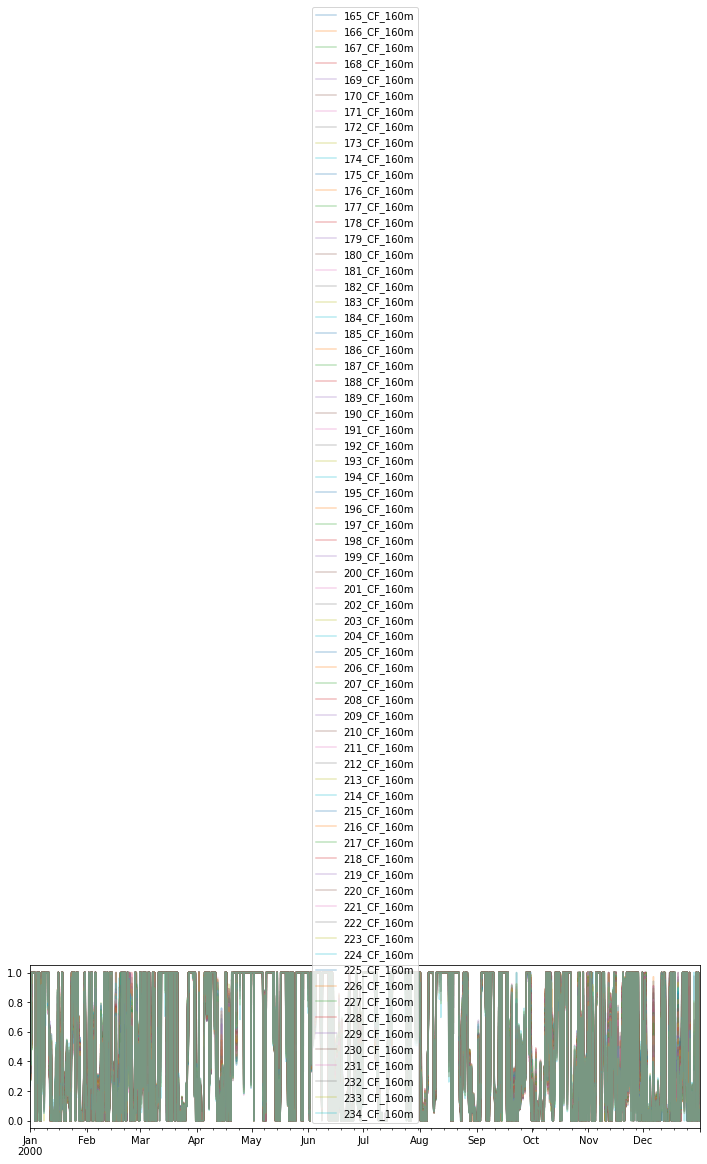

In [118]:
pd.concat(df_list, axis=1).plot(
    figsize=(12, 3), alpha=0.3
)  # .to_csv("offshore_cf.csv")